## Import Libraries & Set Up

In [ ]:
# import library
import warnings
import re
import os
import sys
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)

SEED = 42
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
warnings.filterwarnings('ignore')
np.random.seed(SEED)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12,4)

## Load Dataset

In [ ]:
# read dataset
path = '/content/Data Historis MDKA.csv'

df = pd.read_csv(path)
df.head()

,Tanggal,Terakhir,Pembukaan,Tertinggi,Terendah,Vol.,Perubahan%
0,09/09/2025,2.70,2.68,2.82,2.62,"228,14M","2,27%"
1,08/09/2025,2.64,2.70,2.74,2.62,"184,32M","0,76%"
2,04/09/2025,2.62,2.57,2.75,2.57,"191,36M","2,75%"
3,03/09/2025,2.55,2.62,2.63,2.51,"79,18M","-0,78%"
4,02/09/2025,2.57,2.56,2.62,2.53,"113,69M","3,21%"


## Util Parser

In [ ]:
def parse_indo_number(x: str):
    """
    Mengubah string angka berformat Indonesia ke float:
    - Titik (.) sebagai pemisah ribuan → dihapus
    - Koma (,) sebagai desimal → diganti titik
    - Handle kosong, '-' → NaN
    """
    if pd.isna(x):
        return np.nan
    if isinstance(x, (int, float)):
        return float(x)
    s = str(x).strip()
    if s in ["", "-", "—"]:
        return np.nan
    # Hapus spasi, ganti . ribuan, , desimal
    s = s.replace(" ", "").replace(".", "").replace(",", ".")
    try:
        return float(s)
    except:
        return np.nan

def parse_volume(v: str):
    """
    Mengubah Vol. seperti '12,3K' / '4.5M' / '1,2B' menjadi angka.
    Jika kosong atau '-', return NaN.
    """
    if pd.isna(v):
        return np.nan
    s = str(v).strip().replace(" ", "")
    if s in ["", "-", "—"]:
        return np.nan
    # Pisahkan suffix
    m = re.match(r'^([0-9\.\,]+)([KMB]?)$', s, re.IGNORECASE)
    if not m:
        # Kadang sudah angka biasa
        return parse_indo_number(s)
    num = parse_indo_number(m.group(1))
    suf = m.group(2).upper()
    mult = 1.0
    if suf == "K":
        mult = 1e3
    elif suf == "M":
        mult = 1e6
    elif suf == "B":
        mult = 1e9
    return num * mult

def to_pct(s):
    """ 'Perubahan%' → float desimal, contoh '1,23%' -> 0.0123 """
    if pd.isna(s):
        return np.nan
    st = str(s).strip().replace("%", "")
    val = parse_indo_number(st)
    return val / 100.0 if pd.notna(val) else np.nan

def ensure_datetime_col(df, col="Tanggal"):
    """Pastikan kolom tanggal menjadi dtype datetime dan sort ascending."""
    df[col] = pd.to_datetime(df[col], dayfirst=True, errors="coerce")
    df = df.dropna(subset=[col]).sort_values(col).reset_index(drop=True)
    return df

In [ ]:
# Parse tanggal
df = ensure_datetime_col(df, "Tanggal")

# Parse angka (format lokal)
for col in ["Terakhir", "Pembukaan", "Tertinggi", "Terendah"]:
    df[col] = df[col].apply(parse_indo_number)

# Volume & Persen
if "Vol." in df.columns:
    df["Vol."] = df["Vol."].apply(parse_volume)
if "Perubahan%" in df.columns:
    df["Perubahan%"] = df["Perubahan%"].apply(to_pct)

# bersihkan baris kosong untuk close
df = df.dropna(subset=["Terakhir"]).reset_index(drop=True)

## Pre-processing

In [ ]:
# check null value
df.isnull().sum()

,0
Tanggal,0
Terakhir,0
Pembukaan,0
Tertinggi,0
Terendah,0
Vol.,0
Perubahan%,0


In [ ]:
# check duplicated value
df.duplicated().sum()

np.int64(0)

## Feature Engineering

In [ ]:
# Teknis indikator (Close-only)
def SMA(s, w):
  return s.rolling(w).mean()
def EMA(s, span):
  return s.ewm(span=span, adjust=False).mean()

def Bollinger_Bands(close, window=20, n_std=2):
    ma = close.rolling(window).mean()
    sd = close.rolling(window).std()
    return ma, ma + n_std*sd, ma - n_std*sd

def RSI(close, period=14):
    delta = close.diff()
    up = delta.clip(lower=0)
    down = -1*delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/period, adjust=False).mean()
    roll_down = down.ewm(alpha=1/period, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-12)
    return 100 - (100/(1+rs))

def MACD(close, fast=12, slow=26, signal=9):
    ema_fast = EMA(close, fast)
    ema_slow = EMA(close, slow)
    macd = ema_fast - ema_slow
    sig  = EMA(macd, signal)
    hist = macd - sig
    return macd, sig, hist

def add_close_based_indicators(df, close_col="Terakhir"):
    """Tambah semua fitur berbasis close, + lag."""
    close = df[close_col]
    df["ret_1d"]    = close.pct_change()
    df["logret_1d"] = np.log(close / close.shift(1))

    # Moving averages
    df["SMA_5"]  = SMA(close, 5)
    df["SMA_10"] = SMA(close, 10)
    df["SMA_20"] = SMA(close, 20)
    df["EMA_5"]  = EMA(close, 5)
    df["EMA_12"] = EMA(close, 12)
    df["EMA_26"] = EMA(close, 26)

    # Bollinger (pakai std close)
    ma20, bb_up, bb_dn = Bollinger_Bands(close, 20, 2)
    df["BB_MA20"], df["BB_UPPER"], df["BB_LOWER"] = ma20, bb_up, bb_dn
    df["BB_WIDTH"] = (bb_up - bb_dn) / (ma20 + 1e-12)

    # RSI / MACD
    df["RSI_14"] = RSI(close, 14)
    macd, macds, macdh = MACD(close, 12, 26, 9)
    df["MACD"], df["MACDS"], df["MACDH"] = macd, macds, macdh

    # momentum/volatilitas
    df["MOM_5"]  = close - close.shift(5)
    df["RET_5"]  = close.pct_change(5)
    df["RET_7"]  = close.pct_change(7)
    df["VOL_5"]  = df["ret_1d"].rolling(5).std()
    df["VOL_10"] = df["ret_1d"].rolling(10).std()

    # lags
    for k in [1,2,3,5,7,10,14,20]:
        df[f"lag_close_{k}"] = close.shift(k)
        df[f"lag_ret_{k}"]   = df["ret_1d"].shift(k)
    return df

In [ ]:
df = add_close_based_indicators(df, "Terakhir")
df = df.dropna().reset_index(drop=True)  # buang awal yang belum punya indikator

# Target horizon = 7 hari
H = 7
df["Close_next7"] = df["Terakhir"].shift(-H)
df = df.dropna(subset=["Close_next7"]).reset_index(drop=True)

In [ ]:
# feature selection
feature_cols = [
    # level & returns
    "Terakhir", "ret_1d", "logret_1d",
    # MA/EMA
    "SMA_5","SMA_10","SMA_20","EMA_5","EMA_12","EMA_26",
    # Bollinger (close-only)
    "BB_MA20","BB_UPPER","BB_LOWER","BB_WIDTH",
    # momentum/vol
    "MOM_5","RET_5","RET_7","VOL_5","VOL_10",
    # RSI/MACD
    "RSI_14","MACD","MACDS","MACDH",
    # lags
    "lag_close_1","lag_close_2","lag_close_3","lag_close_5","lag_close_7","lag_close_10","lag_close_14","lag_close_20",
    "lag_ret_1","lag_ret_2","lag_ret_3","lag_ret_5","lag_ret_7","lag_ret_10","lag_ret_14","lag_ret_20",
]

## Build SVM

In [ ]:
# data splitting
X = df[feature_cols].copy()
y = df["Close_next7"].copy()
dates = df["Tanggal"].copy()

In [ ]:
# shape X, y
print(X.shape, y.shape)

(1341, 38) (1341,)


In [ ]:
# train test split
N = len(df)
train_end = int(0.70 * N)
valid_end = int(0.85 * N)

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_valid, y_valid = X.iloc[train_end:valid_end], y.iloc[train_end:valid_end]
X_test,  y_test  = X.iloc[valid_end:], y.iloc[valid_end:]
dates_test       = dates.iloc[valid_end:]

print(f"Samples: total={N}, train={len(X_train)}, valid={len(X_valid)}, test={len(X_test)}")

Samples: total=1341, train=938, valid=201, test=202


In [ ]:
# Pipeline: StandardScaler → PCA → SVM
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(random_state=RANDOM_STATE)),
    ("svr", SVR())
])

param_grid = {
    "pca__n_components": [0.90, 0.95, 0.99, 10, 15, 20],
    "svr__kernel": ["rbf", "linear"],
    "svr__C": [0.1, 1, 5, 10, 20],
    "svr__gamma": ["scale", "auto"],
    "svr__epsilon": [0.01, 0.1, 0.2, 0.5]
}

tscv = TimeSeriesSplit(n_splits=5)

gscv = GridSearchCV(
    pipe,
    param_grid,
    scoring="neg_root_mean_squared_error",
    cv=tscv,
    n_jobs=-1,
    verbose=1
)
gscv.fit(X_train, y_train)
best_model = gscv.best_estimator_

print("\n=== Best Params (CV on Train) ===")
print(gscv.best_params_)
print("Best CV RMSE:", -gscv.best_score_)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits

=== Best Params (CV on Train) ===
{'pca__n_components': 0.9, 'svr__C': 20, 'svr__epsilon': 0.01, 'svr__gamma': 'auto', 'svr__kernel': 'rbf'}
Best CV RMSE: 0.5357017326149067


In [ ]:
# retrain di (train+valid)
X_trv = pd.concat([X_train, X_valid], axis=0)
y_trv = pd.concat([y_train, y_valid], axis=0)
best_model.fit(X_trv, y_trv)

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=0.9, random_state=42)),
                ('svr', SVR(C=20, epsilon=0.01, gamma='auto'))])

In [ ]:
# evaluasi historical t+7
y_pred_test = best_model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred_test)
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)
print(f"\n[Test t+10] RMSE={rmse:.4f} | MAE={mae:.4f} | R²={r2:.4f}")


[Test t+10] RMSE=0.1005 | MAE=0.2665 | R²=0.2803


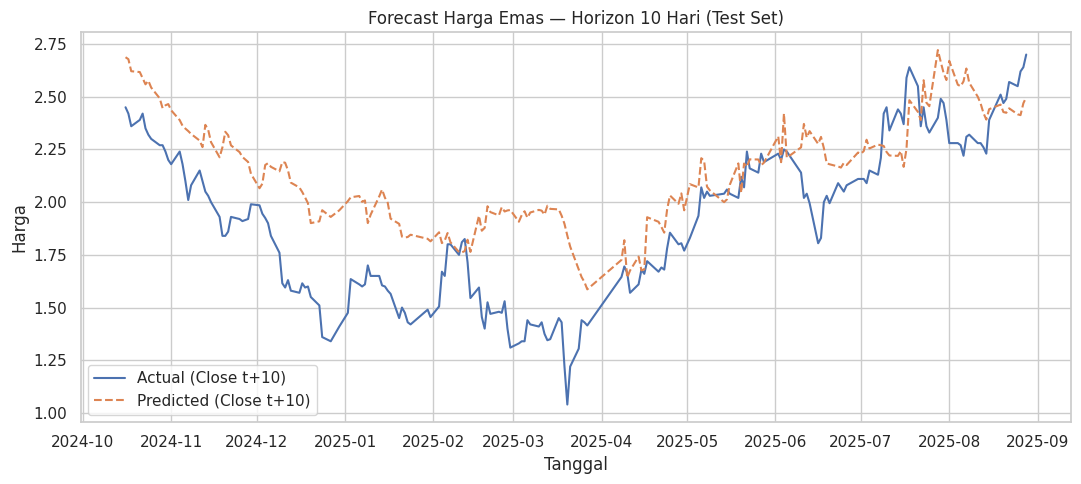

In [ ]:
# Actual vs Predicted (t+7)
plt.figure(figsize=(11,5))
plt.plot(dates_test, y_test.values, label="Actual (Close t+10)")
plt.plot(dates_test, y_pred_test, "--", label="Predicted (Close t+10)")
plt.title("Forecast Harga Emas — Horizon 10 Hari (Test Set)")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

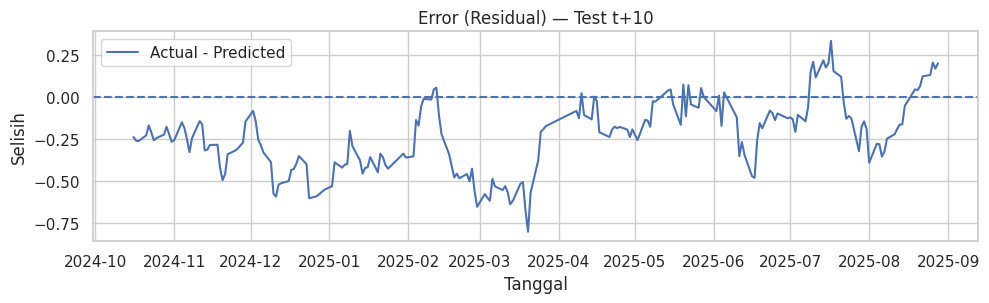

In [ ]:
# Error plot
plt.figure(figsize=(10,3.2))
plt.plot(dates_test, (y_test.values - y_pred_test), label="Actual - Predicted")
plt.axhline(0, linestyle="--")
plt.title("Error (Residual) — Test t+10")
plt.xlabel("Tanggal")
plt.ylabel("Selisih")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# PROPER RECURSIVE 7-DAY FORECAST dari titik terakhir
def recompute_close_features_tail(df_tail, keep_cols=("Tanggal","Terakhir")):
    """
    Ambil df tail yang minimal berisi Tanggal & Terakhir,
    hitung ulang semua fitur close-only (fungsi add_close_based_indicators).
    Return df dengan kolom 'feature_cols' siap infer.
    """
    # clone agar tak merusak di luar
    tmp = df_tail.copy()
    # buang kolom feat lama jika ada
    old_cols = set(tmp.columns) - set(keep_cols)
    if old_cols:
        tmp = tmp[list(keep_cols)].copy()
    tmp = add_close_based_indicators(tmp, "Terakhir")
    tmp = tmp.dropna().reset_index(drop=True)
    # hanya kembalikan kolom fitur
    if len(tmp) == 0:
        return pd.DataFrame(columns=feature_cols)
    return tmp[feature_cols].copy()

def recursive_forecast_next_k(df_full, model, horizon=7):
    """
    Menghasilkan prediksi harga untuk 'horizon' hari ke depan secara recursive.
    - df_full: dataframe asli yang minimal punya kolom Tanggal & Terakhir + fitur sebelumnya
    - model: best_model (fit)
    - return: future_dates, future_preds (list)
    """
    # ambil hanya kolom minimal utk pembentukan fitur ulang
    work = df_full[["Tanggal","Terakhir"]].copy()

    future_preds = []
    last_date = work["Tanggal"].iloc[-1]
    for step in range(horizon):
        # hitung fitur dari tail data (butuh cukup panjang untuk MA/EMA/BB/RSI/MACD)
        # ambil tail panjang aman (mis. 200 baris)
        tail = work.tail(300).copy()
        X_tail = recompute_close_features_tail(tail, keep_cols=("Tanggal","Terakhir"))
        if X_tail.empty:
            raise RuntimeError("Tidak cukup data untuk membentuk fitur pada langkah recursive.")

        # ambil baris terakhir sebagai input
        x_infer = X_tail.iloc[[-1]]
        y_hat = model.predict(x_infer)[0]
        future_preds.append(float(y_hat))

        # append prediksi sebagai 'Terakhir' baru (anggap close = prediksi)
        next_date = last_date + pd.offsets.BDay(1)  # asumsi frekuensi hari kerja
        new_row = pd.DataFrame({"Tanggal":[next_date], "Terakhir":[y_hat]})
        work = pd.concat([work, new_row], ignore_index=True)
        last_date = next_date

    future_dates = pd.date_range(start=work["Tanggal"].iloc[-horizon], periods=horizon, freq="B")
    return list(future_dates), future_preds

future_dates, future_preds = recursive_forecast_next_k(df, best_model, horizon=7)

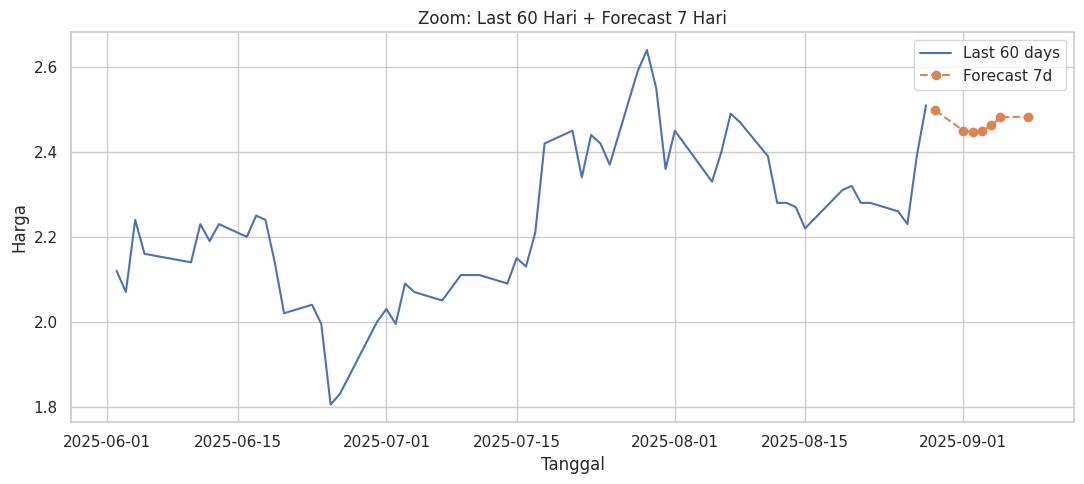

In [ ]:
# gabungkan historis terakhir 60 hari + forecast 7 hari
tail_n = 60
plt.figure(figsize=(11,5))
plt.plot(df["Tanggal"].iloc[-tail_n:], df["Terakhir"].iloc[-tail_n:], label=f"Last {tail_n} days")
plt.plot(future_dates, future_preds, "o--", label="Forecast 7d")
plt.title(f"Zoom: Last {tail_n} Hari + Forecast 7 Hari")
plt.xlabel("Tanggal")
plt.ylabel("Harga")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()